# Práctico librería implicit - ALS y BPR


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1afzSaU23AIP9ZA2NDXCGNWTwf-gsaCg0?usp=sharing)


Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    708      0 --:--:-- --:--:-- --:--:--   708
100 1546k  100 1546k    0     0  2172k      0 --:--:-- --:--:-- --:--:-- 2172k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1010      0 --:--:-- --:--:-- --:--:--  1007
100  385k  100  385k    0     0   685k      0 --:--:-- --:--:-- --:--:--  685k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1272      0 --:--:-- --:--:-- --:--:--  1272
100  230k  100  230k    0     0   523k      0 --:--:-- --:--:-- --:--:--  225M


In [2]:
!pip3 install implicit --upgrade

Requirement already up-to-date: implicit in /usr/local/lib/python3.6/dist-packages (0.4.2)


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:**
Minimiza dos funciones de "pérdida" de manera alternante. Primero usa la matriz del usuario como una fija y hace la optimización con el gradiente con la matriz de items y luego hace el reverso (fija items y lo ahce con la del usuario)

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
256     When the Cats Away (Chacun cherche son chat) (...
292                                       Rosewood (1997)
754                                     Red Corner (1997)
273                                           Heat (1995)
813                          Celluloid Closet, The (1995)
258                                        Contact (1997)
595                                       Fan, The (1996)
125                                     Phenomenon (1996)
1012                                 Private Parts (1997)
285                                 Secrets & Lies (1996)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06049493634059188
ndcg: 0.327718223583461


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [18]:
import matplotlib.pyplot as plt

def evaluate_error_model(factors=100, iterations=10):
    model = implicit.als.AlternatingLeastSquares(factors=factors, iterations=iterations, use_gpu=False)
    model.fit(matrix)
    return evaluate_model(model, n=10)

In [25]:
# hacemos los gráficos con los factores
factors = [i for i in range(10, 151, 10)]
iterat = [i for i in range(1, 16)]

maprec_f = []
maprec_i = []
ndcg_f = []
ndcg_i = []

for f in factors:
    mrr, nrr = evaluate_error_model(factors=f)
    maprec_f.append(mrr)
    ndcg_f.append(nrr)

for i in iterat:
    mrr, nrr = evaluate_error_model(iterations=i)
    maprec_i.append(mrr)
    ndcg_i.append(nrr)

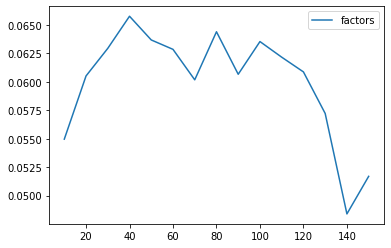

In [30]:
plt.plot(factors, maprec_f, label='factors')
plt.legend()
plt.show()

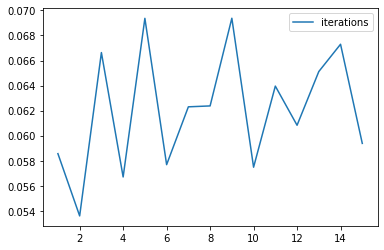

In [31]:
plt.plot(iterat, maprec_i, label='iterations')
plt.legend()
plt.show()

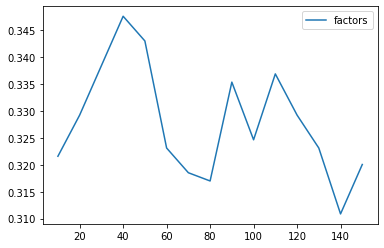

In [32]:
plt.plot(factors, ndcg_f, label='factors')
plt.legend()
plt.show()

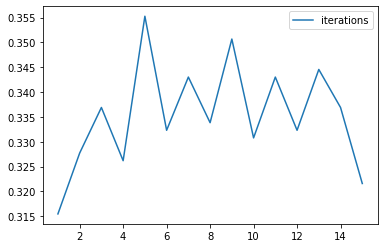

In [33]:
plt.plot(iterat, ndcg_i, label='iterations')
plt.legend()
plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

BPR utiliza pares de de items para poder tener rankings más personalizados para los usuarios. Lo que hace también es optimizar en base al "rank" de los pares usuario-item en vez de simplemente utilizar un puntaje de la interacción

In [34]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [35]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257              Men in Black (1997)
285            Secrets & Lies (1996)
299                   Hoodlum (1997)
746               Real Genius (1985)
244    Smilla's Sense of Snow (1997)
327                  Cop Land (1997)
332            Kiss the Girls (1997)
301                  In & Out (1997)
676             Crucible, The (1996)
267                          unknown
Name: title, dtype: object

In [36]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171              Delicatessen (1991)
209        This Is Spinal Tap (1984)
194                Sting, The (1973)
21     Muppet Treasure Island (1996)
203                Unforgiven (1992)
27                   Bad Boys (1995)
68                  Crow, The (1994)
173       Princess Bride, The (1987)
175                    Brazil (1985)
201              Evil Dead II (1987)
Name: title, dtype: object

In [ ]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05408205018391552
ndcg: 0.3614088820826952


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [45]:
def evaluate_error_model_bpr(factors=400, iterations=40):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
    model.fit(matrix)
    return evaluate_model(model, n=10)

In [46]:
# hacemos los gráficos con los factores
factors = [i for i in range(200, 551, 50)]
iterat = [i for i in range(10, 90, 10)]

maprec_f = []
maprec_i = []
ndcg_f = []
ndcg_i = []

for f in factors:
    mrr, nrr = evaluate_error_model(factors=f)
    maprec_f.append(mrr)
    ndcg_f.append(nrr)

for i in iterat:
    mrr, nrr = evaluate_error_model(iterations=i)
    maprec_i.append(mrr)
    ndcg_i.append(nrr)

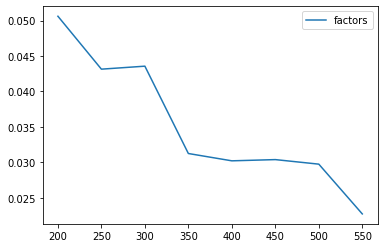

In [47]:
plt.plot(factors, maprec_f, label='factors')
plt.legend()
plt.show()

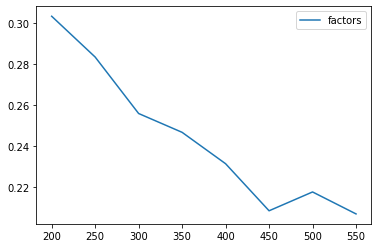

In [48]:
plt.plot(factors, ndcg_f, label='factors')
plt.legend()
plt.show()

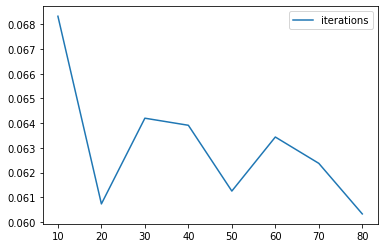

In [51]:
plt.plot(iterat, maprec_i, label='iterations')
plt.legend()
plt.show()

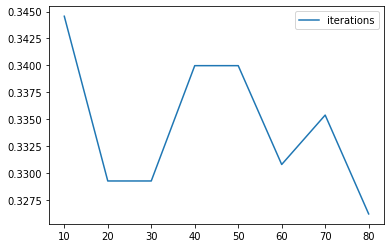

In [50]:
plt.plot(iterat, ndcg_i, label='iterations')
plt.legend()
plt.show()